In [1]:
import os

# 设置可见的 GPU，例如只使用 GPU 0 和 GPU 1
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

dim_feedforward = 2048
n_head = 4
n_layer = 4
scale_ratio = 4

In [2]:
from deepdow.benchmarks import Benchmark, OneOverN, Random, MaximumReturn
from deepdow.callbacks import EarlyStoppingCallback, ModelCheckpointCallback, Callback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.data.synthetic import sin_single
from deepdow.experiments import Run
from deepdow.layers import SoftmaxAllocator
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from deepdow.layers import NumericalMarkowitz
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from os import path
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import torch
import torch.multiprocessing as mp
import yfinance as yf
from finetuning.finetuning_torch import FinetuningConfig, TimesFMFinetuner
from huggingface_hub import snapshot_download
from torch.utils.data import Dataset

from timesfm import TimesFm, TimesFmCheckpoint, TimesFmHparams
from timesfm.pytorch_patched_decoder import PatchedTimeSeriesDecoder
import os
from deepdow.layers import Conv
from deepdow.layers.collapse import AttentionCollapse, AverageCollapse
from deepdow.layers.misc import CovarianceMatrix
import h5py

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


/home/userroot/miniconda3/envs/ts/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Dec 11 2024, 16:28:39) [GCC 11.2.0].


In [3]:
import h5py
import torch
# 函数：向嵌套字典添加新值
def add_to_nested_dict(nested_dict, k1, k2, value):
    # 如果 k1 不存在，创建新的子字典
    if k1 not in nested_dict:
        nested_dict[k1] = {}
    
    # 如果 k2 不存在，创建新的列表
    if k2 not in nested_dict[k1]:
        nested_dict[k1][k2] = []
    
    # 将 value 追加到 k2 对应的列表
    nested_dict[k1][k2].append(value)
from datetime import datetime
all_content = {}
output_file = "hidden_states.h5"
with h5py.File(output_file, "r") as f_read:
    for k in f_read.keys():
        #print("文件中的键：", list(f_read[k]))
        for ds in list(f_read[k]):

            ts = datetime.strptime(ds.split("_")[-1], "%Y-%m-%d %H:%M:%S%z")
            day = str(ts.date())
            #print(day)
            # {k: {ts: f_read[k][ds][:]}}
            # all_content[k] = {ts.date():f_read[k][ds][:]}
            add_to_nested_dict(all_content, k, day, torch.tensor(f_read[k][ds][:]).to(torch.float))
        #data = f_read[k]['hidden_states_2005-10-13 19:00:40+00:00'][:]
        #break
def swap_hierarchy(A):
    """
    交换字典 A 的层级，从 {name: {timestamps: [value, value]}} 转换为
    {timestamps: {name: [value, value]}}.
    
    参数:
        A: 输入字典，结构为 {name: {timestamps: [value, value]}}
    
    返回:
        new_A: 转换后的字典，结构为 {timestamps: {name: [value, value]}}
    """
    new_A = {}
    
    # 遍历原始字典
    for name, timestamp_dict in A.items():
        for timestamp, values in timestamp_dict.items():
            # 如果 timestamp 不在 new_A 中，初始化
            if timestamp not in new_A:
                new_A[timestamp] = {}
            # 将 name 和 values 添加到对应的 timestamp 下
            new_A[timestamp][name] = values
    
    return new_A

# 示例字典
A = {
    "name1": {"2023-01-01": [10, 20], "2023-06-01": [30, 40]},
    "name2": {"2023-01-01": [5, 15], "2023-07-01": [25, 35]}
}

# 转换层级
result = swap_hierarchy(A)
print(result)
def merge_values(A):
    """
    将字典 A 的结构从 {timestamps: {name: [value, value]}} 转换为
    {timestamps: [value, value]}，合并每个 timestamps 下所有 name 的 value。
    
    参数:
        A: 输入字典，结构为 {timestamps: {name: [value, value]}}
    
    返回:
        new_A: 转换后的字典，结构为 {timestamps: [value, value]}
    """
    new_A = {}
    
    # 遍历原始字典
    for timestamp, name_dict in A.items():
        # 合并所有 name 的 value 列表
        merged_values = []
        for values in name_dict.values():
            merged_values.extend(values)
        # 存储到新字典
        new_A[timestamp] = merged_values
    
    return new_A

# 示例字典
A = {
    "2023-01-01": {"name1": [10, 20], "name2": [5, 15]},
    "2023-06-01": {"name1": [30, 40]},
    "2023-07-01": {"name2": [25, 35]}
}

# 合并 value
result = merge_values(A)
print(result)
import torch

def mean_pool_values(A):
    """
    将字典 A 的结构从 {timestamps: [value, value]} 转换为 {timestamps: value}，
    其中 value 是 torch.Tensor，通过平均池化合并每个 timestamps 下的 value 列表。
    
    参数:
        A: 输入字典，结构为 {timestamps: [torch.Tensor, torch.Tensor]}
    
    返回:
        new_A: 转换后的字典，结构为 {timestamps: torch.Tensor}
    """
    new_A = {}
    
    # 遍历原始字典
    for timestamp, value_list in A.items():
        # 将 value 列表堆叠为张量，形状为 (num_values, ...)
        stacked_values = torch.stack(value_list)
        # 沿第0维（num_values）取平均，得到单个张量
        pooled_value = torch.mean(stacked_values, dim=0)
        # 存储到新字典
        new_A[timestamp] = torch.mean(pooled_value, dim=0)
    
    return new_A

# 示例字典
A = {
    "2023-01-01": [torch.tensor([1.0, 2.0]), torch.tensor([3.0, 4.0])],
    "2023-06-01": [torch.tensor([5.0, 6.0]), torch.tensor([7.0, 8.0])],
    "2023-07-01": [torch.tensor([9.0, 10.0])]
}

# 平均池化
result = mean_pool_values(A)
for timestamp, value in result.items():
    print(f"{timestamp}: {value}")
mean_content = mean_pool_values(merge_values(swap_hierarchy(all_content)))
from datetime import datetime

def get_values_before_date(A, cutoff_date_str, date_format="%Y-%m-%d"):
    """
    返回字典 A 中所有 timestamps 小于 cutoff_date 的 value 列表。
    
    参数:
        A: 输入字典，结构为 {timestamps: value}
        cutoff_date_str: 截止日期字符串（如 "2023-06-01"）
        date_format: 日期格式，默认为 "%Y-%m-%d"
    
    返回:
        values: 小于截止日期的所有 value 列表
    """
    # 将截止日期转换为 datetime 对象
    
    cutoff_date = datetime.strptime(str(cutoff_date_str).split(' ')[0], date_format)

    
    # 初始化结果列表
    values = []
    
    # 遍历字典
    for timestamp, value in A.items():
        # 将 timestamp 转换为 datetime 对象
        timestamp_date = datetime.strptime(timestamp, date_format)
        # 如果 timestamp 小于截止日期，添加对应的 value
        if timestamp_date < cutoff_date:
            values.append(value)
    
    return values

# 示例字典
import torch
A = {
    "2023-01-01": torch.tensor([1.0, 2.0]),
    "2023-06-01": torch.tensor([3.0, 4.0]),
    "2023-07-01": torch.tensor([5.0, 6.0]),
    "2024-01-01": torch.tensor([7.0, 8.0])
}

# 示例调用
cutoff_date = "2023-07-01"
result = get_values_before_date(A, cutoff_date)
print(f"Values before {cutoff_date}: {result}")

{'2023-01-01': {'name1': [10, 20], 'name2': [5, 15]}, '2023-06-01': {'name1': [30, 40]}, '2023-07-01': {'name2': [25, 35]}}
{'2023-01-01': [10, 20, 5, 15], '2023-06-01': [30, 40], '2023-07-01': [25, 35]}
2023-01-01: 2.5
2023-06-01: 6.5
2023-07-01: 9.5
Values before 2023-07-01: [tensor([1., 2.]), tensor([3., 4.])]


In [4]:
from deepdow.callbacks import (
    BenchmarkCallback,
    EarlyStoppingException,
    ProgressBarCallback,
    ValidationCallback,
)
from diffcp import SolverError
import datetime
import time
class DeepRun(Run):
    def __init__(self, network, loss, train_dataloader, val_dataloaders=None, metrics=None, benchmarks=None, device=None, dtype=None, optimizer=None, callbacks=None):
        super().__init__(network, loss, train_dataloader, val_dataloaders, metrics, benchmarks, device, dtype, optimizer, callbacks)
    
    def launch(self, n_epochs=1):
        """Launch the training and logging loop.

        Parameters
        ----------
        n_epochs : int
            Number of epochs.
        """
        try:
            self.network.to(device=self.device, dtype=self.dtype)
            # Train begin
            if self.current_epoch == -1:
                self.on_train_begin(metadata={"n_epochs": n_epochs})

            for _ in range(n_epochs):
                self.current_epoch += 1
                # Epoch begin
                self.on_epoch_begin(metadata={"epoch": self.current_epoch})

                for batch_ix, (
                    X_batch,
                    y_batch,
                    timestamps,
                    asset_names,
                ) in enumerate(self.train_dataloader):
                    # Batch begin
                    self.on_batch_begin(
                        metadata={
                            "asset_names": asset_names,
                            "batch": batch_ix,
                            "epoch": self.current_epoch,
                            "timestamps": timestamps,
                            "X_batch": X_batch,
                            "y_batch": y_batch,
                        }
                    )

                    # Get batch
                    X_batch, y_batch = X_batch.to(self.device).to(
                        self.dtype
                    ), y_batch.to(self.device).to(self.dtype)

                    # Make sure network on the right device and train mode
                    self.network.train()

                    # Forward & Backward
                    weights = self.network(X_batch, y_batch, timestamps, asset_names)
                    loss_per_sample = self.loss(weights, y_batch)
                    loss = loss_per_sample.mean()
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                    # Switch back to eval mode
                    self.network.eval()

                    # Batch end
                    self.on_batch_end(
                        metadata={
                            "asset_names": asset_names,
                            "batch": batch_ix,
                            "batch_loss": loss.item(),
                            "epoch": self.current_epoch,
                            "timestamps": timestamps,
                            "weights": weights,
                            "X_batch": X_batch,
                            "y_batch": y_batch,
                        }
                    )

                # Epoch end
                self.on_epoch_end(
                    metadata={
                        "epoch": self.current_epoch,
                        "n_epochs": n_epochs,
                    }
                )

            # Train end
            self.on_train_end()

        except (EarlyStoppingException, KeyboardInterrupt, SolverError) as ex:
            print("Training interrupted")
            time.sleep(1)

            self.on_train_interrupt(
                metadata={"exception": ex, "locals": locals()}
            )

        return self.history



In [5]:
import pandas as pd
df = pd.read_parquet('df.parquet')#[-500:]

In [6]:
#df = raw_df[-300:]
df


Ticker            AAPL                                                  \
Price            Close        High         Low        Open      Volume   
Date                                                                     
2006-03-27    1.790870    1.847145    1.787560    1.816148  1108072000   
2006-03-28    1.766796    1.809829    1.752952    1.794481  1370322800   
2006-03-29    1.875734    1.881452    1.735498    1.779435  2346834000   
2006-03-30    1.888373    1.904924    1.851659    1.890479  1390650800   
2006-03-31    1.887471    1.914254    1.873026    1.903421   815357200   
...                ...         ...         ...         ...         ...   
2025-03-20  214.100006  217.490005  212.220001  213.990005    48862900   
2025-03-21  218.270004  218.839996  211.279999  211.559998    94127800   
2025-03-24  220.729996  221.479996  218.580002  221.000000    44299500   
2025-03-25  223.750000  224.100006  220.080002  220.770004    34493600   
2025-03-26  221.529999  225.020004  220.470001  223.509995    34466100   

Ticker            AMGN                                               ...  \
Price            Close        High         Low        Open   Volume  ...   
Date                                                                 ...   
2006-03-27   50.995205   51.176585   50.409216   50.751043  5824900  ...   
2006-03-28   50.653378   51.497484   50.402238   51.218439  9298900  ...   
2006-03-29   50.241776   51.030077   50.095278   50.667317  6687100  ...   
2006-03-30   50.660351   51.148675   50.311546   50.332474  7623500  ...   
2006-03-31   50.751030   51.169594   50.688248   50.848695  8828100  ...   
...                ...         ...         ...         ...      ...  ...   
2025-03-20  315.040009  315.989990  312.239990  314.179993  2049700  ...   
2025-03-21  316.040009  316.489990  311.160004  311.820007  9995000  ...   
2025-03-24  314.380005  317.579987  313.429993  315.000000  2439400  ...   
2025-03-25  306.859985  314.220001  303.510010  313.980011  2565300  ...   
2025-03-26  305.709991  309.089996  304.350006  306.440002  2375200  ...   

Ticker            WBA                                                   WMT  \
Price           Close       High        Low       Open    Volume      Close   
Date                                                                          
2006-03-27  26.269537  26.292878  25.732708  25.919431   4527400  10.771452   
2006-03-28  25.645187  26.111994  25.417620  26.053644   5734800  10.726527   
2006-03-29  25.674360  25.872753  25.633515  25.732710   3052700  10.793917   
2006-03-30  25.394274  25.721039  25.306747  25.569326   3189000  10.706310   
2006-03-31  25.166706  25.557655  25.108354  25.405944   3325900  10.611959   
...               ...        ...        ...        ...       ...        ...   
2025-03-20  11.120000  11.200000  11.120000  11.160000  12048300  85.574997   
2025-03-21  11.100000  11.190000  11.080000  11.110000  37249800  85.980003   
2025-03-24  11.150000  11.150000  11.090000  11.120000  12137700  87.489998   
2025-03-25  11.120000  11.170000  11.120000  11.150000   7945800  84.760002   
2025-03-26  11.100000  11.150000  11.100000  11.120000   9880500  85.209999   

Ticker                                                 
Price            High        Low       Open    Volume  
Date                                                   
2006-03-27  10.850076  10.760221  10.825366  25991400  
2006-03-28  10.854571  10.706310  10.771454  30132900  
2006-03-29  10.823120  10.670365  10.737757  26045400  
2006-03-30  10.823122  10.627686  10.793919  29380800  
2006-03-31  10.769206  10.602973  10.769206  30273000  
...               ...        ...        ...       ...  
2025-03-20  86.841523  85.285790  85.574997  18185500  
2025-03-21  86.230003  84.779999  85.279999  26797200  
2025-03-24  87.650002  86.349998  86.470001  17900700  
2025-03-25  87.309998  84.620003  86.760002  27908600  
2025-03-26  85.559998  84.570000  85.190002  27228800  

[4781 

In [7]:
horizon_len = 14
patch_len = 32
patch_num = 5
batch_size = 256
hidden_size = 128
channels = ['Close', 'Volume'] #['Close', 'High','Low',	'Open',	'Volume']
device = 'cuda'

In [8]:
def get_model(load_weights: bool = False, horizon_len: int = 7):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  repo_id = "google/timesfm-2.0-500m-pytorch"
  hparams = TimesFmHparams(
      backend=device,
      per_core_batch_size=32,
      horizon_len=horizon_len,
      num_layers=50,
      use_positional_embedding=False,
      context_len=2048,  # Context length can be anything up to 2048 in multiples of 32
      input_patch_len=patch_len
  )
  tfm = TimesFm(hparams=hparams,
                checkpoint=TimesFmCheckpoint(huggingface_repo_id=repo_id))

  model = PatchedTimeSeriesDecoder(tfm._model_config)
  if load_weights:
    checkpoint_path = path.join(snapshot_download(repo_id), "torch_model.ckpt")
    loaded_checkpoint = torch.load(checkpoint_path, weights_only=True)
    model.load_state_dict(loaded_checkpoint)
  return model, hparams, tfm._model_config

In [9]:
from deepdow.utils import raw_to_Xy


n_timesteps = len(df)  # 20
n_channels = len(channels)  # 2
n_assets = len(df.columns.levels[0])  # 2

lookback, gap, horizon = patch_len*patch_num, 2, horizon_len

X, timestamps, y, asset_names, indicators = raw_to_Xy(df,
                                                      lookback=lookback,
                                                      gap=gap,
                                                      freq="B",
                                                      horizon=horizon,
                                                      included_indicators=channels)

n_samples =  n_timesteps - lookback - horizon - gap + 1  # 10

# assert X.shape == (n_samples, n_channels, lookback, n_assets)
# assert timestamps[0] == raw_df.index[lookback]
# assert asset_names == tickers
# assert indicators == ['Close', 'High', 'Low', 'Open', 'Volume']

In [10]:
print(lookback)
print(df.index[lookback])
print(timestamps[0])
print(df.index[0])

160
2006-11-10 00:00:00
2006-11-06 00:00:00
2006-03-27 00:00:00


In [11]:
print('X: {}, y: {}'.format(X.shape, y.shape))

X: (4782, 2, 160, 30), y: (4782, 2, 14, 30)


In [12]:
n_samples

4606

In [13]:
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
#indices_test = list(range(split_ix + lookback + horizon, n_samples))
indices_test = list(range(split_ix + horizon, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                     indices_test[0], indices_test[-1]))

Train range: 0:3683
Test range: 3698:4605


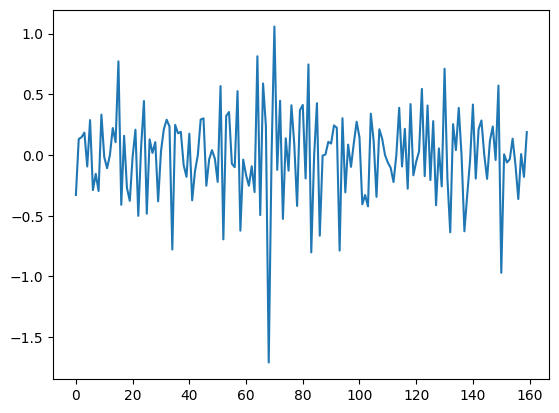

In [14]:
plt.plot(X[1, 1, :, 1])

In [15]:
means, stds = prepare_standard_scaler(X, indices=indices_train)
print('mean: {}, std: {}'.format(means, stds))

mean: [ 0.00042066 -0.00010419], std: [0.0179363  0.34215311]


In [16]:
dataset = InRAMDataset(X, y, timestamps = timestamps, asset_names = asset_names, transform=Scale(means, stds))

In [17]:
dataloader_train = RigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=batch_size, num_workers=16, pin_memory=True)

dataloader_test = RigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=batch_size)

In [18]:
sfm_model, a, b = get_model(load_weights=True)
sfm_model.to('cuda')

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 41445.69it/s]


PatchedTimeSeriesDecoder(
  (input_ff_layer): ResidualBlock(
    (hidden_layer): Sequential(
      (0): Linear(in_features=64, out_features=1280, bias=True)
      (1): SiLU()
    )
    (output_layer): Linear(in_features=1280, out_features=1280, bias=True)
    (residual_layer): Linear(in_features=64, out_features=1280, bias=True)
  )
  (freq_emb): Embedding(3, 1280)
  (horizon_ff_layer): ResidualBlock(
    (hidden_layer): Sequential(
      (0): Linear(in_features=1280, out_features=1280, bias=True)
      (1): SiLU()
    )
    (output_layer): Linear(in_features=1280, out_features=1280, bias=True)
    (residual_layer): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (stacked_transformer): StackedDecoder(
    (layers): ModuleList(
      (0-49): 50 x TimesFMDecoderLayer(
        (self_attn): TimesFMAttention(
          (qkv_proj): Linear(in_features=1280, out_features=3840, bias=True)
          (o_proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (

In [19]:

from torch import dropout


class DeepNet(torch.nn.Module, Benchmark):
    def generate_square_subsequent_mask(self, sz):
        """生成因果掩码，sz 是目标序列长度"""
        mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
        return mask
    def __init__(self, n_assets, lookback, channels, hidden_size = 128, p=0.4, max_weight=1., n_output_channels = 4, dim_feedforward=96, scale_ratio = 2, n_layer = 4, n_head = 2):
        super().__init__()

        super().__init__()

        n_features =  patch_num * 128 # 输入特征数
        predict_patch_num = (horizon_len + 128 -1) // 128
        scale_ratio = scale_ratio
        self.CollapseChannel = Conv(n_input_channels=channels,
             n_output_channels=1,
             kernel_size=3,
             method='2D')
        self.embedding_layer_3 = nn.Linear(n_assets*channels, n_assets*scale_ratio, bias=True)
        self.embedding_layer_2 = nn.Linear(n_assets*channels, n_assets*scale_ratio, bias=True)
        self.embedding_layer_1 = nn.Linear(n_assets*channels, n_assets*scale_ratio, bias=True)
        self.cross_embedding_layer = nn.Linear(896, n_assets*scale_ratio, bias=True)
        # 参数
        d_model = n_assets*scale_ratio  # 隐藏维度
        nhead = n_head      # 注意力头数
        num_encoder_layers = n_layer  # 编码器层数
        num_decoder_layers = n_layer  # 解码器层数
        dim_feedforward = dim_feedforward  # 前馈层中间维度
        dropout = 0.2
        self.encoder_layer = nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True
            )
        self.encoder_layer_2 = nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True
            )
        self.decoder_layer = nn.TransformerDecoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True
            )
        self.cross_decoder_layer = nn.TransformerDecoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True
            )
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        self.encoder_2 = nn.TransformerEncoder(self.encoder_layer_2, num_layers=num_encoder_layers)
        self.cross_decoder = nn.TransformerDecoder(self.cross_decoder_layer, num_layers=num_decoder_layers)
        self.mask = self.generate_square_subsequent_mask(lookback).to('cuda')
        self.mask_2 = self.generate_square_subsequent_mask(horizon_len).to('cuda')
        layers = []

        layers.append(nn.Linear(n_features, 1))
        layers.append(nn.ReLU())
        self.CollapseSFM = nn.Sequential(*layers)
        
        self.layer_L3 = AverageCollapse()
        self.layer_L4 = CovarianceMatrix(sqrt=False)
        self.layer_L5 = NumericalMarkowitz(n_assets)
        # Dropout 层
        self.dropout_layer = nn.Dropout(p=p)
        
        # 10 层网络
        layers = []
        # 第 1 层：输入层
        layers.append(nn.Linear(patch_num*1280, hidden_size))
        layers.append(nn.ReLU())
        
        
        # 将所有层组合成 Sequential
        self.network = nn.Sequential(*layers)
        self.dense_layer = torch.nn.Linear(n_assets*scale_ratio, n_assets, bias=True)
        self.dense_layer_2 = torch.nn.Linear(channels, 1, bias=True)
        
        # Softmax 分配层和温度参数
        self.allocate_layer = SoftmaxAllocator(temperature=None, n_assets= n_assets, formulation='variational', max_weight=1)
        self.temperature = nn.Parameter(torch.ones(1), requires_grad=True)
        

    def forward(self, x, y_batch=None, timestamps=None, asset_names=None):

        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        # if timestamps is not None:
        #     script_features = []
        #     for timestamp in timestamps:
        #         script_f = get_values_before_date(mean_content, timestamp)[-200:]
        #         script_f = torch.stack(script_f, dim=0) # 200, 896
        #         script_features.append(script_f)
        #     script_tensor = torch.stack(script_features, dim=0)
        
        # script_tensor = script_tensor.to(device)
        # script_tensor = self.cross_embedding_layer(script_tensor)
        
        
        n_samples, channels, lookback, n_assets = x.shape
        if y_batch is not None:
            y = y_batch.permute(0, 2, 1,3) #B, channels, horizon_len, n_assets
            y = y.reshape(n_samples, horizon_len, -1)
            y = self.embedding_layer_3(y)
        
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(n_samples, n_assets*channels, lookback)
        m_list = [] 
        
        if True: #y_batch is None:
            for i in range(n_samples):
                m = x[i, :,:]
                input_padding = torch.zeros_like(m).to(device)
                freq = torch.tensor([0], dtype=torch.long).to(device)
                with torch.no_grad():
                    m = sfm_model(m, input_padding, freq) # B, patch_num, 128, 10 (mean +  9 quantiles)
                #m = sfm_model(m, input_padding, freq)
                m = m[:,:,:,0] # channels*n_assets, patch_num, 128
                m = m[:,-1,:] # B,  last patch predicted first patch's 128  prediction
                m_list.append(m)
            m = torch.stack(m_list, dim=0) # B, channels*n_assets, 128
            m = m[:,:,:horizon_len]
            m = m.permute(0,2,1) #B, horizon_len, n_assets*channels
            m = self.embedding_layer_1(m) #B, horizon_len, n_assets*sclale_ratio
            #m = self.dropout_layer(m)
            #m = self.encoder(m) #B, horizon_len, n_assets*sclale_ratio
        #m = m[:,-1,:]
        # m = m[:,:,0:horizon_len]  # B, channels*n_assets, horizon_len
        # m = m.permute(0,2,1) # B, horizon_len, channels*n_assets
        # m = self.embedding_layer_1(m) # B, horizon_len, n_assets*sclale_ratio
        # # m 不需要std化 
        x = x.permute(0, 2, 1) # B, lookback, n_assets*channels
        x = self.embedding_layer_2(x) # B, lookback, n_assets*sclale_ratio
        x = self.encoder_2(x)
        #x = self.dropout_layer(x)
        if y_batch is not None:
            x = self.decoder(y, x, self.generate_square_subsequent_mask(y.shape[1])) + m
        else:
            x = self.decoder(m, x, self.generate_square_subsequent_mask(m.shape[1])) + m
        #x = self.cross_decoder(x, m, self.mask_2)
        x = x[:,-1, :] #B, 1, n_assets*sclale_ratio
        #x = x + m
        x = x.reshape(n_samples, -1) #B, 1, n_assets*sclale_ratio
        x = self.dense_layer(x) # B, lookback, n_assets*sclale_ratio
        # # #x = self.cross_decoder(x, script_tensor)
        # # x = self.decoder(m, x) # B, patch_num, n_assets*sclale_ratio
        # # #x = self.decoder(x, m) # B, lookback, n_assets*scale_ratio
        # # #x = x.permute(0, 2, 1)
        # x = self.decoder(m, m, self.mask) # B, horizon_len, n_assets*sclale_ratio
        #x = x.reshape(n_samples,  -1) #B, n_assets, horizon_len*scale_ratio
        #x = x[:,-1, :]
        
        
        #x = self.dropout_layer(x)
        #m = self.dense_layer_2(m)
        
        #x = self.dense_layer(x)
        x = x.squeeze(-1)
        # 计算权重
        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

In [20]:
from deepdow.nn import BachelierNet

n_input_channels = len(channels)
max_weight = 1
hidden_size = 32
network = None


In [21]:
if True:
    #network = GreatNet(n_assets, lookback, channels=n_channels, hidden_size=hidden_size,p=0.4)
    network = DeepNet(n_assets, lookback, channels=n_channels, hidden_size=hidden_size,p=0.4, dim_feedforward=dim_feedforward, scale_ratio=scale_ratio, n_layer=n_layer, n_head=n_head)
else:
    network = BachelierNet(n_input_channels, n_assets, hidden_size=hidden_size, max_weight=max_weight)


In [22]:
network

DeepNet(
  (CollapseChannel): Conv(
    (conv): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (embedding_layer_3): Linear(in_features=60, out_features=120, bias=True)
  (embedding_layer_2): Linear(in_features=60, out_features=120, bias=True)
  (embedding_layer_1): Linear(in_features=60, out_features=120, bias=True)
  (cross_embedding_layer): Linear(in_features=896, out_features=120, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=120, out_features=120, bias=True)
    )
    (linear1): Linear(in_features=120, out_features=2048, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=2048, out_features=120, bias=True)
    (norm1): LayerNorm((120,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((120,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, in

In [23]:
network_to_train = network.train() 

In [24]:
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio(rf=0.000)
#loss = MeanReturns()

In [25]:
#获得时间 作为文件名
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S")
run = DeepRun(network_to_train,
          loss,
          dataloader_train,
          benchmarks={'OneOverN': OneOverN(),
                      'MaximumReturn': MaximumReturn(),
                     },
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True, lr=0.001),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=15),
                     ModelCheckpointCallback(folder_path=f'./models/{date_time}_ffn_{dim_feedforward}_scale_{scale_ratio}_nlayer_{n_layer}_nhead_{n_head}/',
                                             dataloader_name='test',
                                             metric_name='loss')],
          device=device
          )

#

In [26]:
history = run.launch(5)

model          metric  epoch  dataloader
MaximumReturn  loss    -1     test         -0.008
OneOverN       loss    -1     test         -0.039


Epoch 0:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4: 100%|██████████| 15/15 [05:19<00:00, 21.27s/it, loss=-0.12954, test_loss=-0.05279]


In [27]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # double check number of samples each epoch
print(per_epoch_results.mean())  # mean loss per epoch

dataloader  metric  model          epoch
test        loss    MaximumReturn  -1       908
                    OneOverN       -1       908
                    network         0       908
                                    1       908
                                    2       908
                                    3       908
                                    4       908
Name: value, dtype: int64
dataloader  metric  model          epoch
test        loss    MaximumReturn  -1      -0.008
                    OneOverN       -1      -0.039
                    network         0      -0.046
                                    1      -0.048
                                    2      -0.042
                                    3      -0.050
                                    4      -0.053
Name: value, dtype: float32


<Axes: xlabel='epoch'>

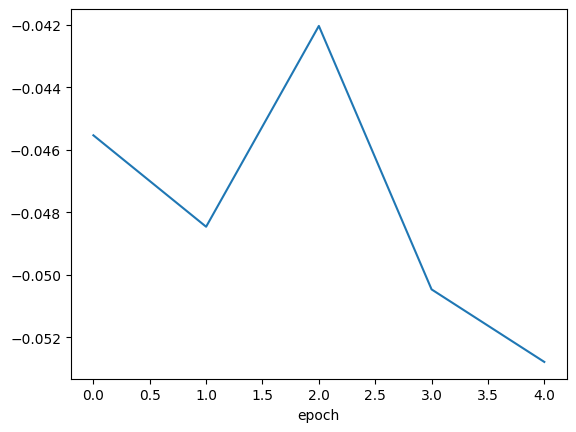

In [28]:
per_epoch_results.mean()['test']['loss']['network'].plot()

In [29]:
from json import load

model_path = f'./models/{date_time}_ffn_{dim_feedforward}_scale_{scale_ratio}_nlayer_{n_layer}_nhead_{n_head}/'
#获得model_path下日期最新的文件
best_model_file = model_path + sorted(os.listdir(model_path), key=lambda x: os.path.getmtime(os.path.join(model_path, x)), reverse=True)[0]
print(f'best model file: {best_model_file}')

loaded_network = torch.load(best_model_file, weights_only=False)
loaded_network.eval()

best model file: ./models/2025-04-21 19-20-30_ffn_2048_scale_4_nlayer_4_nhead_4/model_04__-0.0528.pth


DeepNet(
  (CollapseChannel): Conv(
    (conv): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (embedding_layer_3): Linear(in_features=60, out_features=120, bias=True)
  (embedding_layer_2): Linear(in_features=60, out_features=120, bias=True)
  (embedding_layer_1): Linear(in_features=60, out_features=120, bias=True)
  (cross_embedding_layer): Linear(in_features=896, out_features=120, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=120, out_features=120, bias=True)
    )
    (linear1): Linear(in_features=120, out_features=2048, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=2048, out_features=120, bias=True)
    (norm1): LayerNorm((120,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((120,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, in

In [30]:
network = network.eval()

In [31]:
benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    #'MaximumReturn': MaximumReturn(),  # random allocation that is however close 1OverN
    #'network': network,
    'best_network': loaded_network
}

In [32]:
metrics = {
    'MaxDD': MaximumDrawdown(),
    'Sharpe': SharpeRatio(),
    'MeanReturn': MeanReturns()
}

In [33]:
metrics_table = generate_metrics_table(benchmarks,
                                       dataloader_test,
                                       metrics,
                                       device='cuda')

array([<Axes: title={'center': 'MaxDD'}, xlabel='timestamp'>,
       <Axes: title={'center': 'Sharpe'}, xlabel='timestamp'>,
       <Axes: title={'center': 'MeanReturn'}, xlabel='timestamp'>],
      dtype=object)

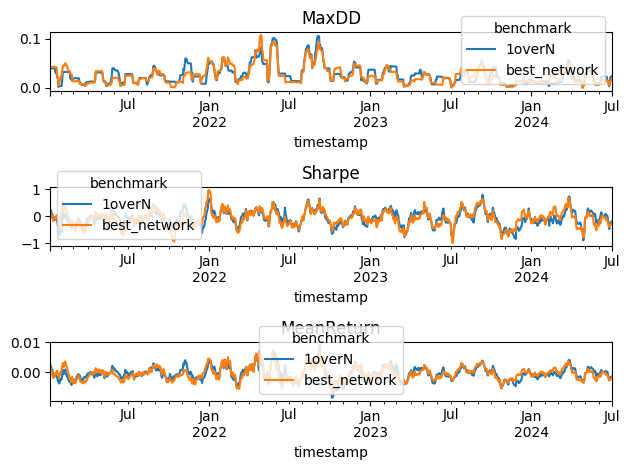

In [34]:
plot_metrics(metrics_table)

In [35]:
weight_table = generate_weights_table(network, dataloader_test,device = device)

<Axes: >

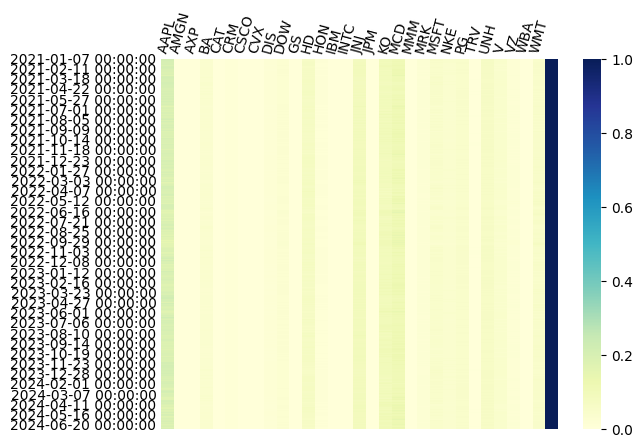

In [36]:
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)

<Axes: >

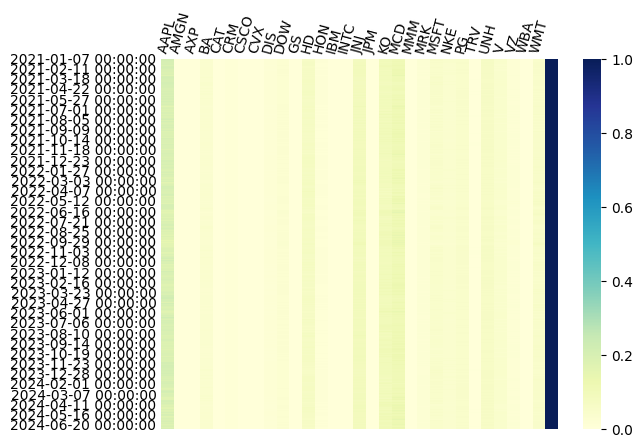

In [37]:
weight_table = generate_weights_table(loaded_network, dataloader_test,device = device)
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)

In [38]:
pd.set_option('display.precision', 10)
print(weight_table.iloc[-1])

AAPL   0.195
AMGN   0.001
AXP    0.001
BA     0.035
CAT    0.002
CRM    0.010
CSCO   0.001
CVX    0.001
DIS    0.016
DOW    0.028
GS     0.000
HD     0.062
HON    0.011
IBM    0.001
INTC   0.001
JNJ    0.089
JPM    0.001
KO     0.104
MCD    0.118
MMM    0.001
MRK    0.019
MSFT   0.045
NKE    0.035
PG     0.047
TRV    0.004
UNH    0.066
V      0.043
VZ     0.019
WBA    0.001
WMT    0.047
Name: 2024-07-01 00:00:00, dtype: float32
